# Experiences de l'article APVP

Ce notebook permet de retrouver toutes les figures produites pour l'article "Cartographie des recommandations vidéos faites aux comptes vides de YouTube" soumis à APVP 2023

In [1]:
from persona_metrics import EDM2RecommandationComparator, SimpleRankedRecommandationComparator
def make_report_from_parquet(parquet_path):
    comparator = EDM2RecommandationComparator()
    comparator.read_parquet(parquet_path)
    comparator.make_report()
    return comparator

## Étalonnage des mesures

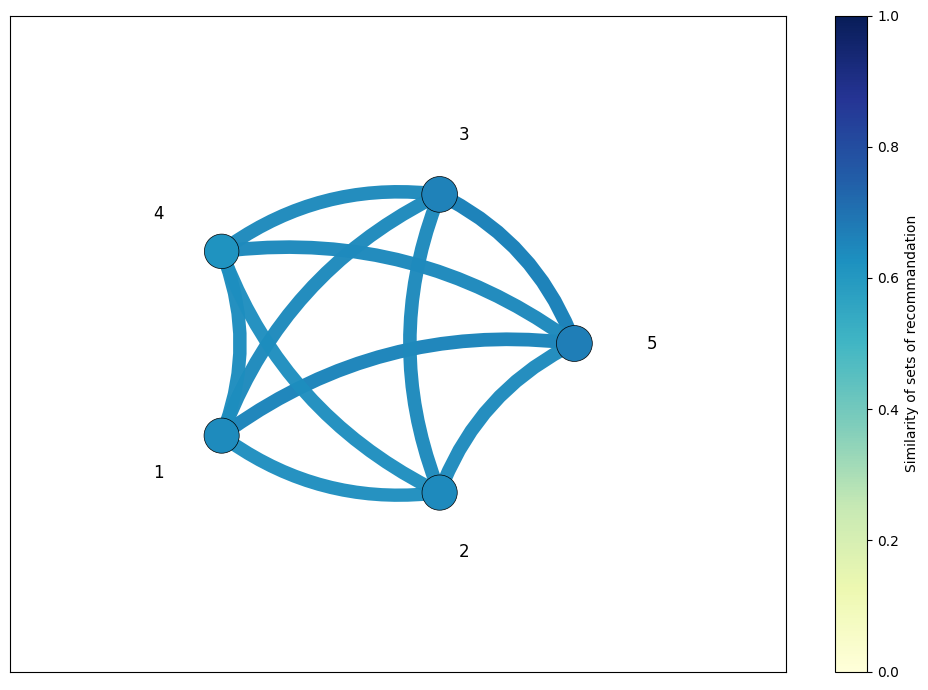

alt.VConcatChart(...)

shape: (15, 4)
┌───────────┬───────────┬────────────────────────┬─────────────────────────────┐
│ cluster_1 ┆ cluster_2 ┆ mean distance adjusted ┆ standard deviation adjusted │
│ ---       ┆ ---       ┆ ---                    ┆ ---                         │
│ str       ┆ str       ┆ f64                    ┆ f64                         │
╞═══════════╪═══════════╪════════════════════════╪═════════════════════════════╡
│ 1         ┆ 1         ┆ 35.963138              ┆ 0.0                         │
│ 1         ┆ 2         ┆ 37.032388              ┆ 1.634704                    │
│ 1         ┆ 3         ┆ 35.767173              ┆ 0.865731                    │
│ 1         ┆ 4         ┆ 36.342638              ┆ 2.217986                    │
│ 1         ┆ 5         ┆ 35.037943              ┆ 1.57739                     │
│ 2         ┆ 2         ┆ 35.687869              ┆ 0.0                         │
│ 2         ┆ 3         ┆ 35.856001              ┆ 1.517057                    │
│ 2         ┆

In [2]:
make_report_from_parquet("../data/etalonnage.parquet")

## Impact du décalage temporel

Graphes temporels (un peu plus manuel). Le temps de calcul des distances est très long, on sauve les résultats dans un fichier intermédiaire

In [3]:
# parquet_path = "../data/influence_temporelle.parquet"
# comparator = EDM2RecommandationComparator()
# comparator.read_parquet(parquet_path)
# comparator.make_report()
# comparator.mean_distances.write_parquet("../data/collecte_temporelle_distances.parquet")

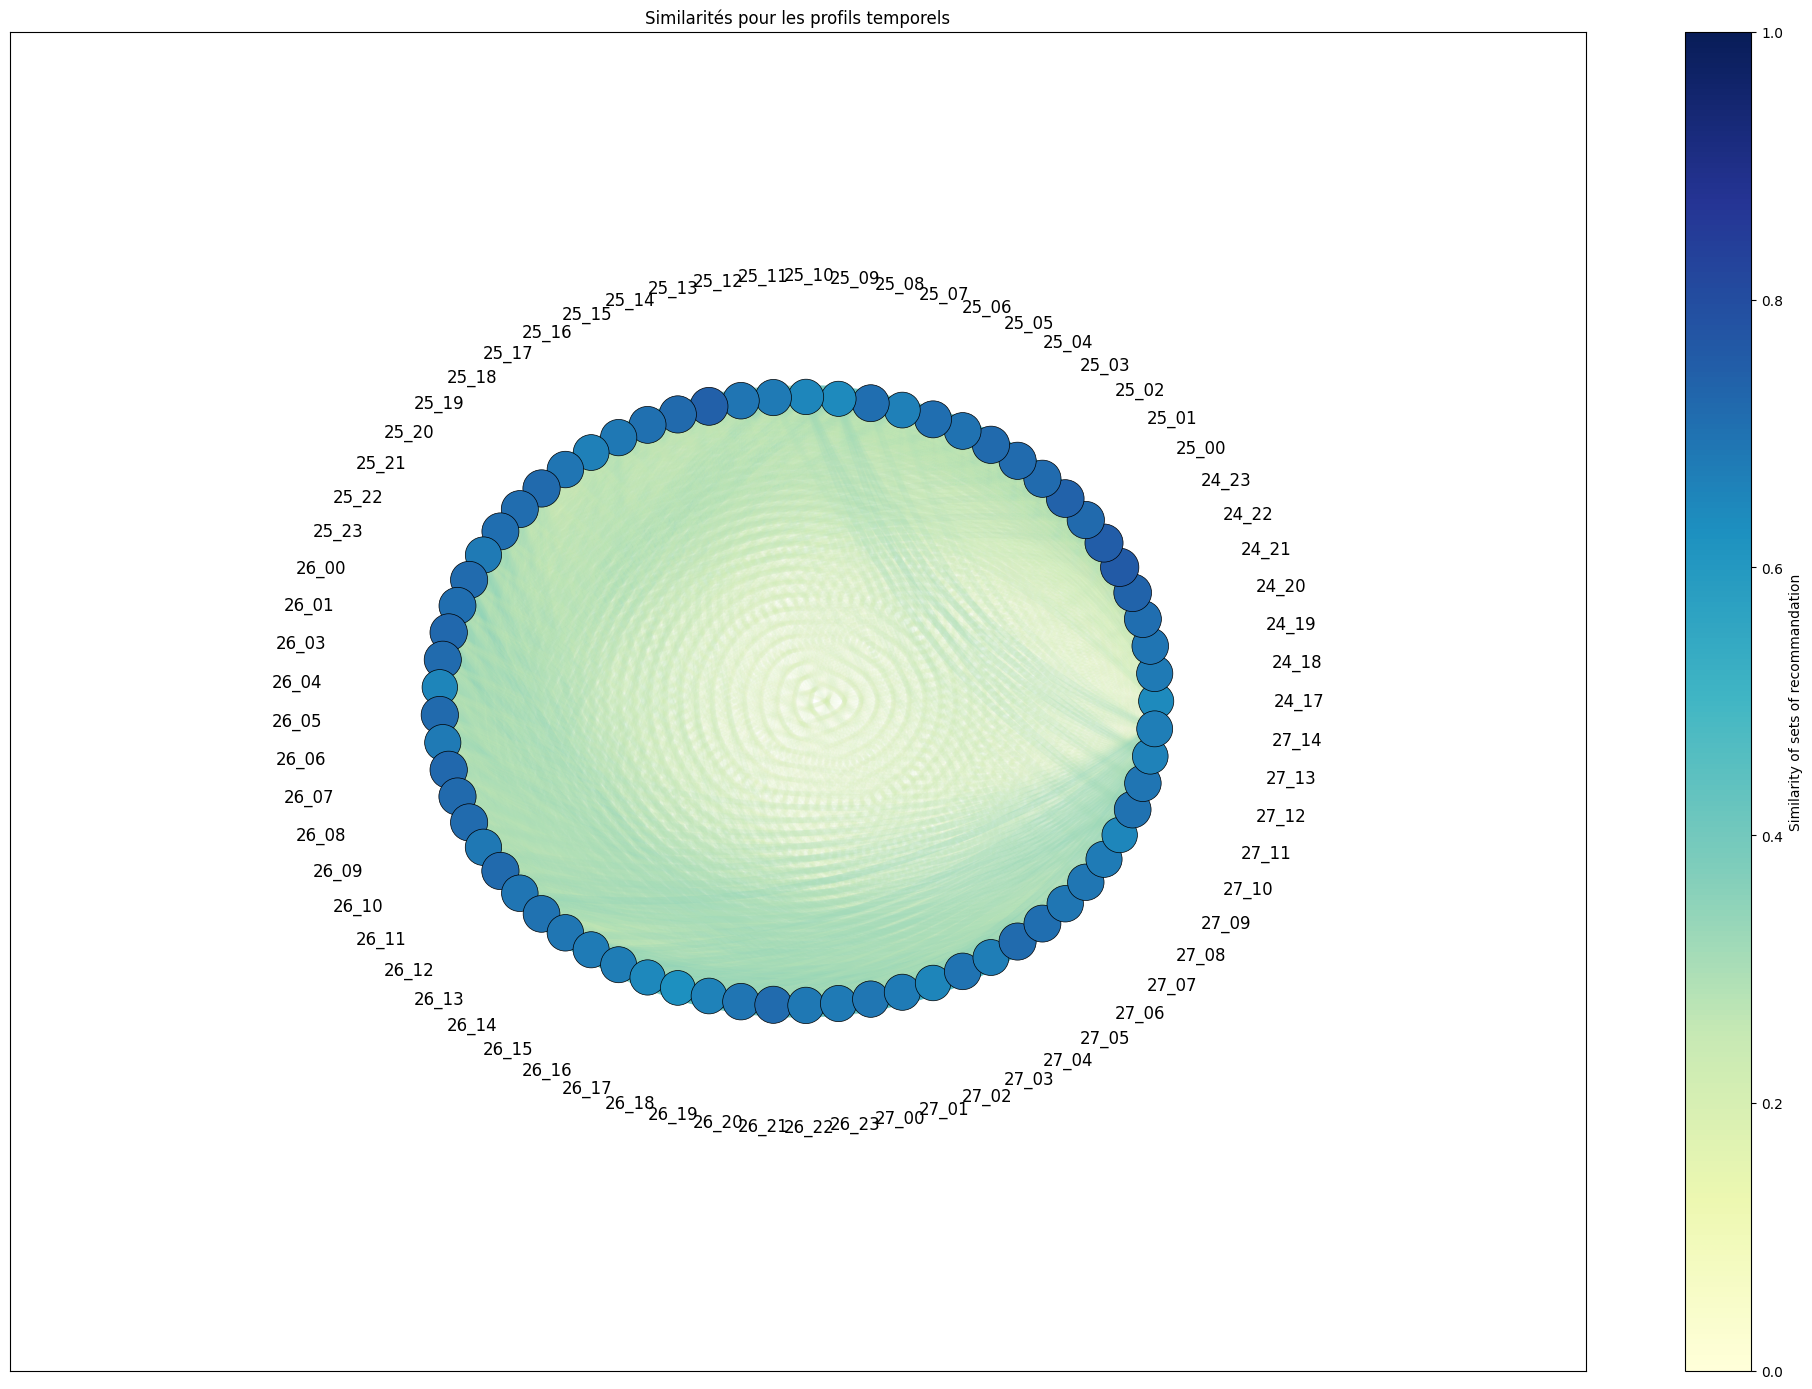

In [4]:
import polars as pl
from persona_metrics.edge_graph import build_chord_plot
from persona_metrics.utils import augment_mean_with_time, get_timestamp_mappings
proper_mapping, timing_to_distance = get_timestamp_mappings(pl.read_parquet("../data/influence_temporelle.parquet"))
mean_distances = pl.read_parquet("../data/collecte_temporelle_distances.parquet")
hour_mean_distance = mean_distances.select(
    pl.col("cluster_1").map_dict(proper_mapping),
    pl.col("cluster_2").map_dict(proper_mapping),
    pl.all().exclude("cluster_1", "cluster_2")
)
build_chord_plot(
    hour_mean_distance.sort("cluster_1", "cluster_2"), 
    edges_attenuation_factor=2,
    figsize=(20, 14),
    graph_title="Similarités pour les profils temporels",
    max_color_value=1
)

Ce graphe n'a pas été inclus dans l'article, pour des raisons de lisibilité

In [5]:
import altair as alt
augmented_dataframe = augment_mean_with_time(mean_distances, proper_mapping, timing_to_distance)
mean_by_time_distance = augmented_dataframe.groupby("time_distance").agg([
    pl.col("mean distance").mean(),
]).filter(pl.col("time_distance") < 72)
pandas_df = mean_by_time_distance.to_pandas()
pandas_df["similarité moyenne"] = 1 - pandas_df["mean distance"]

In [6]:
alt.Chart(pandas_df).mark_line(point=True).encode(
    x=alt.X('time_distance', title="nombre d'heures séparant les deux collectes"),
    y="similarité moyenne"
)

alt.Chart(...)

In [7]:
def get_stats_from_distances(distance):
    return augmented_dataframe.filter(pl.col("time_distance") == distance).select(
        (1 - pl.col("mean distance")).alias("similarité")
    ).describe()
get_stats_from_distances(0)

shape: (7, 2)
┌────────────┬────────────┐
│ describe   ┆ similarité │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 71.0       │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.695827   │
│ std        ┆ 0.027847   │
│ min        ┆ 0.626426   │
│ max        ┆ 0.761601   │
│ median     ┆ 0.695305   │
└────────────┴────────────┘

In [8]:
get_stats_from_distances(1)

shape: (7, 2)
┌────────────┬────────────┐
│ describe   ┆ similarité │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 68.0       │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.587932   │
│ std        ┆ 0.046517   │
│ min        ┆ 0.491646   │
│ max        ┆ 0.674229   │
│ median     ┆ 0.59373    │
└────────────┴────────────┘

## Influence de l'IP

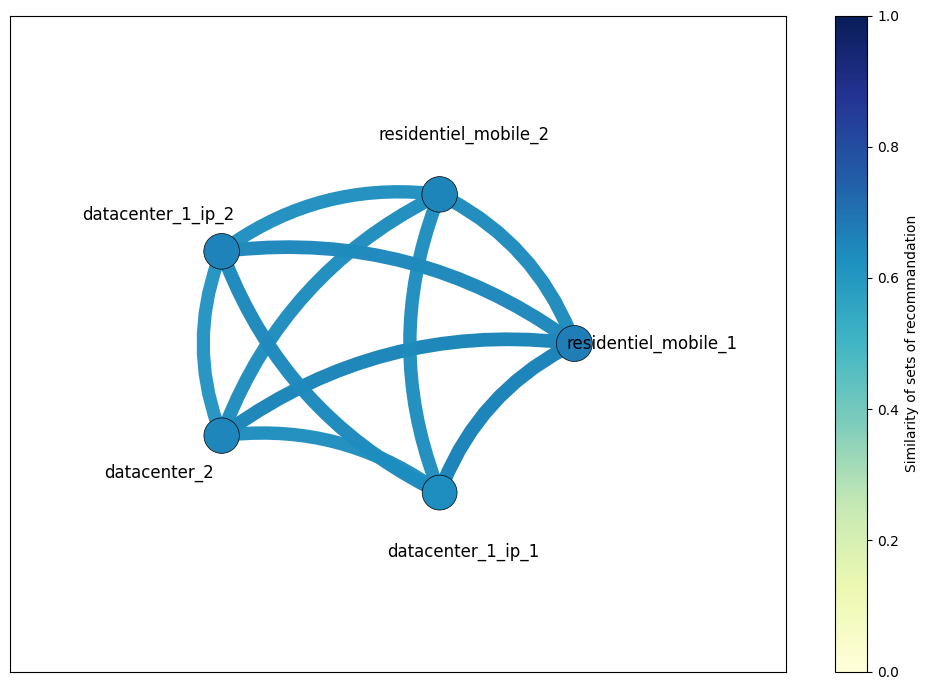

alt.VConcatChart(...)

shape: (15, 4)
┌──────────────────────┬──────────────────────┬────────────────────────┬────────────────────┐
│ cluster_1            ┆ cluster_2            ┆ mean distance adjusted ┆ standard deviation │
│ ---                  ┆ ---                  ┆ ---                    ┆ adjusted           │
│ str                  ┆ str                  ┆ f64                    ┆ ---                │
│                      ┆                      ┆                        ┆ f64                │
╞══════════════════════╪══════════════════════╪════════════════════════╪════════════════════╡
│ datacenter_1_ip_1    ┆ datacenter_1_ip_1    ┆ 36.979926              ┆ 0.0                │
│ datacenter_1_ip_1    ┆ datacenter_1_ip_2    ┆ 35.812807              ┆ 2.424331           │
│ datacenter_1_ip_1    ┆ datacenter_2         ┆ 36.687519              ┆ 1.976185           │
│ datacenter_1_ip_1    ┆ residentiel_mobile_1 ┆ 34.400332              ┆ 2.137402           │
│ datacenter_1_ip_1    ┆ residentiel_mobile_2

In [9]:
make_report_from_parquet("../data/influence_de_l_ip.parquet")

## Influence de l'acceptation des cookies

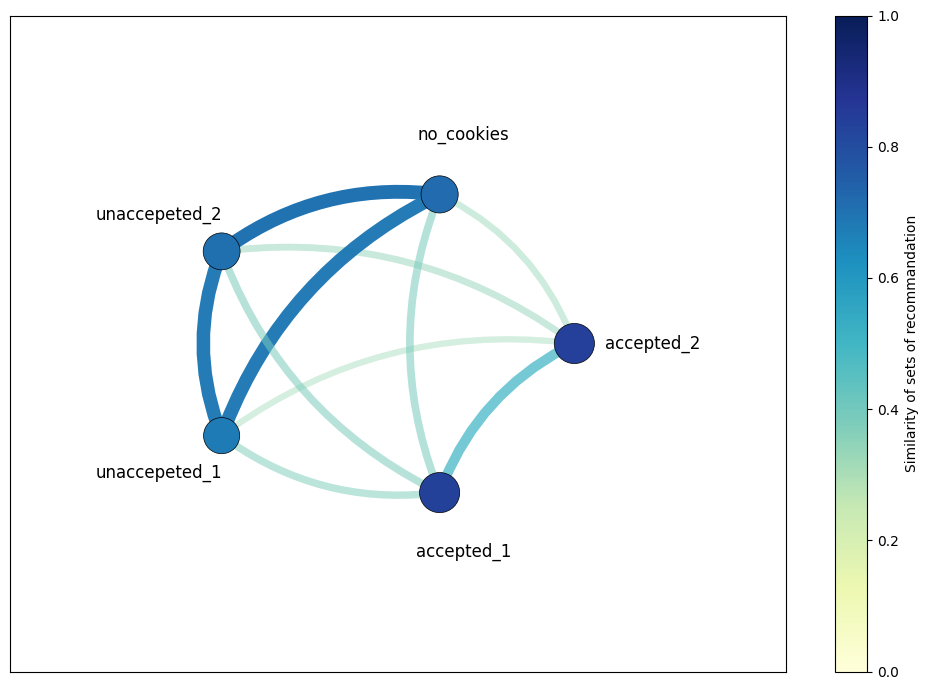

alt.VConcatChart(...)

shape: (15, 4)
┌───────────────┬───────────────┬────────────────────────┬─────────────────────────────┐
│ cluster_1     ┆ cluster_2     ┆ mean distance adjusted ┆ standard deviation adjusted │
│ ---           ┆ ---           ┆ ---                    ┆ ---                         │
│ str           ┆ str           ┆ f64                    ┆ f64                         │
╞═══════════════╪═══════════════╪════════════════════════╪═════════════════════════════╡
│ accepted_1    ┆ accepted_1    ┆ 16.438852              ┆ 0.0                         │
│ accepted_1    ┆ accepted_2    ┆ 49.555196              ┆ 0.906758                    │
│ accepted_1    ┆ no_cookies    ┆ 61.23048               ┆ 0.811857                    │
│ accepted_1    ┆ unaccepeted_1 ┆ 62.703811              ┆ 0.732136                    │
│ accepted_1    ┆ unaccepeted_2 ┆ 61.635566              ┆ 0.535252                    │
│ accepted_2    ┆ accepted_2    ┆ 16.339308              ┆ 0.0                         │
│ acce

In [10]:
make_report_from_parquet("../data/influence_de_l_acceptation_des_cookies_1.parquet")

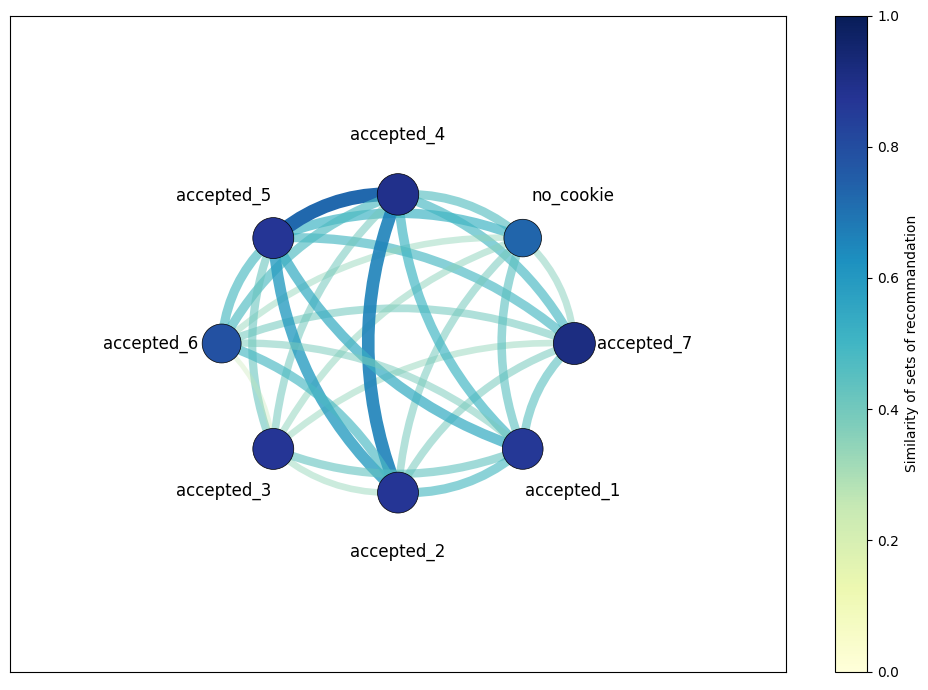

alt.VConcatChart(...)

shape: (36, 4)
┌────────────┬────────────┬────────────────────────┬─────────────────────────────┐
│ cluster_1  ┆ cluster_2  ┆ mean distance adjusted ┆ standard deviation adjusted │
│ ---        ┆ ---        ┆ ---                    ┆ ---                         │
│ str        ┆ str        ┆ f64                    ┆ f64                         │
╞════════════╪════════════╪════════════════════════╪═════════════════════════════╡
│ accepted_1 ┆ accepted_1 ┆ 13.961259              ┆ 0.0                         │
│ accepted_1 ┆ accepted_2 ┆ 52.432193              ┆ 0.695355                    │
│ accepted_1 ┆ accepted_3 ┆ 56.548108              ┆ 0.878745                    │
│ accepted_1 ┆ accepted_4 ┆ 50.175967              ┆ 0.127577                    │
│ accepted_1 ┆ accepted_5 ┆ 47.148102              ┆ 1.200191                    │
│ accepted_1 ┆ accepted_6 ┆ 61.660264              ┆ 1.368684                    │
│ accepted_1 ┆ accepted_7 ┆ 55.32565               ┆ 0.757332           

In [11]:
make_report_from_parquet("../data/influence_de_l_acceptation_des_cookies_2.parquet")

## Influence de l'utilisation d'un compte

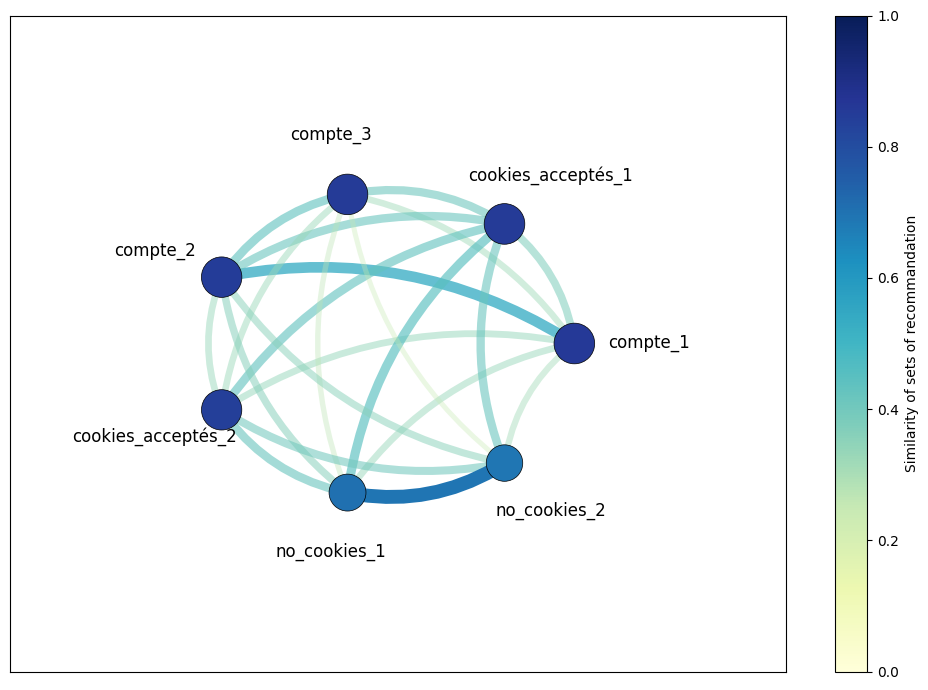

alt.VConcatChart(...)

shape: (28, 4)
┌────────────────────┬────────────────────┬────────────────────────┬─────────────────────────────┐
│ cluster_1          ┆ cluster_2          ┆ mean distance adjusted ┆ standard deviation adjusted │
│ ---                ┆ ---                ┆ ---                    ┆ ---                         │
│ str                ┆ str                ┆ f64                    ┆ f64                         │
╞════════════════════╪════════════════════╪════════════════════════╪═════════════════════════════╡
│ compte_1           ┆ compte_1           ┆ 14.389351              ┆ 0.0                         │
│ compte_1           ┆ compte_2           ┆ 46.860007              ┆ 1.521094                    │
│ compte_1           ┆ compte_3           ┆ 67.720449              ┆ 0.513211                    │
│ compte_1           ┆ cookies_acceptés_1 ┆ 62.00631               ┆ 0.359672                    │
│ compte_1           ┆ cookies_acceptés_2 ┆ 65.967614              ┆ 0.533474                 

In [12]:
make_report_from_parquet("../data/influence_de_l_utilisation_d_un_compte.parquet")